- v1: works till the categorical pipeline where it errors out for unknown variables
- v2: fully functional
- v3: baseline run (on the old dataset)
- v4: baseline run (on the full 2021.03.17_full_dataset)
- v5: baseline run (on 2021.03.19_full_dataset with all SSURGO variables)
- v6: aoc_roc (on 2021.03.19_full_dataset with all SSURGO variables). Mute the Stacking as it is not possible with RandomizedSearchCV. Have to have a dev split.
- v7: model v7 random state 123 on train/test, model v7.1 random_state 431 on train/dev/test
- v8g: Golden model

- ROC_AUC with lat, lon (baseline)
====================
lr:           0.64103
xgb:          0.82366
voting_clf:   0.83027
lgbm:         0.86395
stacking:     0.85923


- v9: without lat, lon

- ROC_AUC without lat, lon
=======================
lr:           0.64211
xgb:          0.8031
voting_clf:   0.83105
lgbm:         0.85952
stacking:     0.85427

- v9.1: without lat, lon, potential_wetland

- ROC_AUC without lat, lon, potential_wetland
===============
lr:           0.63992
xgb:          0.79093
voting_clf:   0.82987
lgbm:         0.85143
stacking:     0.84328

- v9.2: without lat, lon, potential_wetland, district

- ROC_AUC without lat, lon, potential_wetland, district
===============
lr:           0.64208
xgb:          0.77907
voting_clf:   0.79829
lgbm:         0.82675
stacking:     0.82185

- v9.3: without lat, lon, potential_wetland, district and flodfreqdc and drclassdcd as ordinal

- ROC_AUC on Test
===============
lr:           0.6382
xgb:          0.73089
voting_clf:   0.79126
lgbm:         0.82512
stacking:     0.8195

- v9.4: without lat, lon, potential_wetland, district, county 
- ROC_AUC on Test
===============
lr:           0.6395
xgb:          0.74096
voting_clf:   0.7911
lgbm:         0.82448
stacking:     0.82343

- v9.5: without lat, lon, potential_wetland, district, county, mukey
- ROC_AUC on Test
===============
lr:           0.65309
xgb:          0.75117
voting_clf:   0.77845
lgbm:         0.80626
stacking:     0.80424


# Constants and Imports


In [561]:
model_dict = {}
file_param_dict = {}
golden_models = ["v8g"]

# file params
stop_before_models = False
random_state = 123 # for train, dev, test splits
dev = True

FILE_VERSION = "v9.5"
run_models = True # BEWARE! This overwrites the models stored on disk
run_logistic = True

if FILE_VERSION in golden_models:
    if run_models:
        turn_off_run_models

file_param_dict["random_state"] = random_state
file_param_dict["dev"] = dev

In [645]:
# !pip install lightgbm
# !pip install xgboost
# !pip install mlxtend
# !pip install seaborn
# !pip install shapely
# !pip install geopandas

# import pickle

In [563]:
%matplotlib inline 

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import joblib
import pickle
from datetime import datetime

from sklearn import model_selection
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# SK-learn libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from lightgbm import LGBMRegressor
from lightgbm import *
from xgboost import XGBRegressor
from xgboost import XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import xgboost
import lightgbm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# SK-learn libraries for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
pass

In [564]:
df_full = pd.read_pickle("2021.03.20_full_dataset")

In [565]:
# flod_ordered = ["None", "Very rare", "Rare", "Occasional", "Frequent", "Very frequent"]
# flod_dict = dict(zip(flod_ordered, range(len(flod_ordered))))

# def flodfreqdc_ordinal(string):
#     try:
#         return flod_dict[string]
#     except:
#         return np.nan
    
    
# df_full["flodfreqdc"] = df_full.apply(lambda x: flodfreqdc_ordinal(x.flodfreqdc), axis=1)

In [566]:
# drclassdcd_ordered = ["Excessively drained", "Somewhat excessively drained", "Well drained", 
# "Moderately well drained", "Somewhat poorly drained", "Poorly drained", "Very poorly drained", "Subaqueous"]

# drclassdcd_dict = dict(zip(drclassdcd_ordered, range(len(drclassdcd_ordered))))

# def drclassdcd_ordinal(string):
#     try:
#         return drclassdcd_dict[string]
#     except:
#         return np.nan
    
# df_full["drclassdcd"] = df_full.apply(lambda x: drclassdcd_ordinal(x.drclassdcd), axis=1)

In [567]:
# df_full = df_full[df_full.district != "Alaska"]

In [568]:
# set(df_full.columns)

In [569]:
# any records where the cwa_determination is contrary to expectations?
good_records = (df_full.apply(lambda x: 
               (np.sum(x.cwa1 + x.cwa2 + x.cwa3 + x.cwa4 + x.cwa5 + 
                       x.cwa6 + x.cwa7 + x.cwa8 + x.cwa9) > 0) * 1 
               == x.cwa_determination, 
               axis=1))

print("%good records = {}%".format(round(np.mean(good_records) * 100)))

%good records = 98.0%


In [570]:
# peek at not good records
df_full[~good_records].head(3)

,cwa4,cwa8,cwa7,cwa_determination,cwa5,longitude,cwa3,date_issued_or_denied,latitude,Index,...,nwi_SUBCLASS_NAME_non_persistent_2500m,nwi_SPLIT_SUBCLASS_NAME_lichen_2500m,nwi_WATER_REGIME_NAME_zzz_2500m,nwi_WATER_REGIME_NAME_permanently_flooded_2500m,nwi_SPLIT_CLASS_NAME_emergent_2500m,nwi_WATER_REGIME_SUBGROUP_zzz_2500m,nwi_WATER_REGIME_SUBGROUP_freshwater_tidal_2500m,nwi_CLASS_NAME_rocky_shore_2500m,county,state
36,0,0,0,1,0,-77.58614,0,02/14/2017,43.10595,37,...,0,0,0,19,0,0,0,0,Monroe,36
50,0,0,0,1,0,-78.89428,0,03/14/2018,43.19710,51,...,0,0,14,10,0,0,0,0,Niagara,36
56,0,0,0,1,0,-78.98265,0,07/12/2017,43.13072,57,...,0,0,0,5,0,0,0,0,Niagara,36


# Train-Dev-Test Splits

In [571]:
# filter out the bad records

df_full = df_full[good_records]

if dev:
    df, df_test = train_test_split(df_full, test_size=0.2, random_state = random_state) # 20% test
    df, df_dev = train_test_split(df, test_size=0.25, random_state = random_state) # 60% train, 20% dev
else:
    df, df_test = train_test_split(df_full, test_size=0.2, random_state = random_state) # 80% train, 20% test
    df_dev = df_test.copy()
    
# df, df_test = train_test_split(df_full, test_size=0.95, random_state = 123)

# EDA

### Remove cols with all NaNs

In [572]:
nan_cols = []
for col in df.columns:
  nan_frac = np.mean(df[str(col)].isna())
  if nan_frac == 1:
    nan_cols.append(col)
nan_cols
df.drop(nan_cols, inplace=True, axis=1)

In [573]:
"county" in df_full.columns

True

# Feature Selection

In [574]:
df_num_features = pd.DataFrame(df.describe().columns)
for count, col in enumerate(df.describe().columns):
  print(count, col)

# 5, 7, 14, 17, 19:445

0 cwa4
1 cwa8
2 cwa7
3 cwa_determination
4 cwa5
5 longitude
6 cwa3
7 latitude
8 Index
9 cwa1
10 rha_determination
11 cwa9
12 cwa2
13 rha2
14 potential_wetland
15 cwa6
16 rha1
17 mukey
18 wtdepaprju
19 iccdcd
20 aws0150wta
21 brockdepmi
22 iccdcdpct
23 hydclprs
24 aws050wta
25 pondfreqpr
26 niccdcd
27 awmmfpwwta
28 aws0100wta
29 slopegradw
30 slopegradd
31 aws025wta
32 urbrecptwt
33 niccdcdpct
34 wtdepannmi
35 slope_stdev_200m
36 transition_8_200m
37 seasonality_mean_200m
38 transition_0_200m
39 recurrence_min_200m
40 elevation_min_200m
41 seasonality_min_200m
42 transition_2_200m
43 slope_min_200m
44 transition_3_200m
45 seasonality_stdev_200m
46 slope_mean_200m
47 recurrence_mean_200m
48 transition_5_200m
49 transition_7_200m
50 elevation_mean_200m
51 slope_max_200m
52 elevation_max_200m
53 seasonality_max_200m
54 transition_6_200m
55 transition_4_200m
56 elevation_stdev_200m
57 transition_1_200m
58 recurrence_max_200m
59 recurrence_stdev_200m
60 transition_9_200m
61 fl_totdasqkm_sum_

## Numerical Feature Selection

In [575]:
# numerical features of interest: 
# imp_num_feature_list = [5, 7,14, 17] + list(range(19, 445)) #[2, 3, 17] + list(range(21, 93))
imp_num_feature_list = list(range(19, 445)) #[2, 3, 17] + list(range(21, 93)) # no lat, lon, potential_wetland, district, mukey


imp_num_feature = df_num_features.loc[imp_num_feature_list]
imp_num_feature = list(imp_num_feature.values.flatten())


## Categorical Feature Selection

In [576]:
# call out the important categorical features

set(df.columns) - set(df.describe().columns)
# imp_cat_feature = ['district', 'flodfreqdc', 'drclassdcd', 'county', 'jurisdiction_type']
imp_cat_feature = ['jurisdiction_type']

# Order Train-Dev-Test splits


In [577]:
# re-arrange so numerical columns go first, then the categorical
df1 = df[imp_num_feature]
df2 = df[imp_cat_feature]

# train
df_X_combined_ordered = pd.concat([df1, df2], axis=1)

# dev
df_dev_X = pd.concat([df_dev[imp_num_feature], df_dev[imp_cat_feature]], axis=1)


# test
df_test_X = pd.concat([df_test[imp_num_feature], df_test[imp_cat_feature]], axis=1)


df_X_combined_ordered.columns #44
df_X_combined_ordered.shape # (10000, 44)
df_test_X.shape # (4500, 44)

(2866, 427)

In [578]:
# fraction of nan's in each variable
for var in df_X_combined_ordered.describe().columns:
  if np.mean(df_X_combined_ordered[str(var)].isna()) != 0:
    print(var, round(np.mean(df_X_combined_ordered[str(var)].isna()), 2))

iccdcd 0.88
aws0150wta 0.04
brockdepmi 0.04
iccdcdpct 0.04
hydclprs 0.04
aws050wta 0.04
pondfreqpr 0.04
niccdcd 0.11
awmmfpwwta 0.04
aws0100wta 0.04
slopegradw 0.04
slopegradd 0.04
aws025wta 0.04
urbrecptwt 0.04
niccdcdpct 0.04
wtdepannmi 0.04
slope_stdev_200m 0.02
transition_8_200m 0.95
seasonality_mean_200m 0.81
transition_0_200m 0.99
recurrence_min_200m 0.79
elevation_min_200m 0.02
seasonality_min_200m 0.82
transition_2_200m 0.96
slope_min_200m 0.02
transition_3_200m 0.99
seasonality_stdev_200m 0.82
slope_mean_200m 0.02
recurrence_mean_200m 0.78
transition_5_200m 0.86
transition_7_200m 0.96
elevation_mean_200m 0.02
slope_max_200m 0.02
elevation_max_200m 0.02
seasonality_max_200m 0.82
transition_6_200m 0.94
transition_4_200m 0.91
elevation_stdev_200m 0.02
transition_1_200m 0.9
recurrence_max_200m 0.79
recurrence_stdev_200m 0.79
transition_9_200m 1.0
fl_length_sum_200m 0.08
fl_length_mean_200m 0.08
transition_2_2500m 0.41
recurrence_stdev_2500m 0.07
seasonality_max_2500m 0.11
recurren

In [579]:
# impute 0's into wb_area_mean, fl_length_sum, fl_length_mean because they were
# assigned np.nan if they were absent
# A non-existent water feature should be assigned 0 given definition of each

def fill_na(df):
  try:
    df.fl_length_sum_200m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_mean_200m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_sum_2500m = df.fl_length_sum_200m.fillna(0)
    df.fl_length_mean_2500m = df.fl_length_sum_200m.fillna(0)
  except:
    pass
  return df

df_X_combined_ordered = fill_na(df_X_combined_ordered)
df_dev_X_combined_ordered = fill_na(df_dev_X)
df_test_X_combined_ordered = fill_na(df_test_X)


In [580]:
# fraction of nan's in each variable
def print_na(df_X_combined_ordered):
  for var in df_X_combined_ordered.describe().columns:
    if np.mean(df_X_combined_ordered[str(var)].isna()) != 0:
      print(var, round(np.mean(df_X_combined_ordered[str(var)].isna()), 2))

print_na(df_X_combined_ordered)      
print()
print_na(df_dev_X_combined_ordered)
print()
print_na(df_test_X_combined_ordered)

iccdcd 0.88
aws0150wta 0.04
brockdepmi 0.04
iccdcdpct 0.04
hydclprs 0.04
aws050wta 0.04
pondfreqpr 0.04
niccdcd 0.11
awmmfpwwta 0.04
aws0100wta 0.04
slopegradw 0.04
slopegradd 0.04
aws025wta 0.04
urbrecptwt 0.04
niccdcdpct 0.04
wtdepannmi 0.04
slope_stdev_200m 0.02
transition_8_200m 0.95
seasonality_mean_200m 0.81
transition_0_200m 0.99
recurrence_min_200m 0.79
elevation_min_200m 0.02
seasonality_min_200m 0.82
transition_2_200m 0.96
slope_min_200m 0.02
transition_3_200m 0.99
seasonality_stdev_200m 0.82
slope_mean_200m 0.02
recurrence_mean_200m 0.78
transition_5_200m 0.86
transition_7_200m 0.96
elevation_mean_200m 0.02
slope_max_200m 0.02
elevation_max_200m 0.02
seasonality_max_200m 0.82
transition_6_200m 0.94
transition_4_200m 0.91
elevation_stdev_200m 0.02
transition_1_200m 0.9
recurrence_max_200m 0.79
recurrence_stdev_200m 0.79
transition_9_200m 1.0
transition_2_2500m 0.41
recurrence_stdev_2500m 0.07
seasonality_max_2500m 0.11
recurrence_min_2500m 0.07
transition_9_2500m 0.89
elevati

# Offline OHE to keep track of variable names

In [581]:
# ohe-hot-encode the columns
# get_dummies only encodes cat columns
df_X_combined_dummies_ordered = pd.get_dummies(df_X_combined_ordered)
# df_X_combined_dummies_ordered.columns # 90

df_dev_X_combined_dummies_ordered = pd.get_dummies(df_dev_X_combined_ordered)
df_test_X_combined_dummies_ordered = pd.get_dummies(df_test_X_combined_ordered)

In [582]:
print(df_X_combined_ordered.shape)
print(df_dev_X_combined_ordered.shape)
print(df_test_X_combined_ordered.shape)
print(df_X_combined_dummies_ordered.shape)
print(df_dev_X_combined_dummies_ordered.shape)
print(df_test_X_combined_dummies_ordered.shape)

(8596, 427)
(2866, 427)
(2866, 427)
(8596, 429)
(2866, 429)
(2866, 429)


# Pipeline

In [583]:
# impute categorical data

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
  """
  By inheriting TransformerMixin, you get fit_transform method for free 
  if you implement fit and transform methods
  """ 

  def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
  def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X], 
            index=X.columns)
        return self

  def transform(self, X, y=None):
        return X.fillna(self.fill)



In [584]:
# Pipeline for numerical columns
# 1. fill NA's with median values
# 2. scale them

# num_pipeline_impute_ss = Pipeline([        # should be list of tuples
#                           ("num_imputer", SimpleImputer(strategy="median")),
#                           ("std_scaler", StandardScaler())
#                           ])                      

# num_pipeline_impute_ss = Pipeline([        # should be list of tuples
#                           ("num_imputer", SimpleImputer(strategy="median")),
#                           ("robust_scaler", RobustScaler())
#                           ])                      

num_pipeline_impute_ss = Pipeline([        # should be list of tuples
                          ("num_imputer", SimpleImputer(strategy="median"))
                          ])                      


# Pipleline for categorical columns
# 1. fill NA's with most frequent values
# 2. one hot code

# cat_pipeline_impute_ohe = Pipeline([("cat_imputer", DataFrameImputer()),
#                          ("one_hot_encoder", OneHotEncoder(drop="first", \
#                                                            sparse=False))
#                          ])


# you want to do the following where you handle_unknown categories in the 
# test data by ignoring them. However, in the imeplementation, I am using
# df_X_combined_dummies_ordered to indicate the numerical and cat columns 
# hence need to fix the df_X_combined_dummies_ordered such that the first 
# ohe is not dropped (as is being done in immediately above)

cat_pipeline_impute_ohe = Pipeline([("cat_imputer", DataFrameImputer()),
                         ("one_hot_encoder", OneHotEncoder(sparse=False,
                                                           handle_unknown = "ignore"))
                         ])

In [585]:
numericals_list = list(df_X_combined_ordered.describe().columns)
categories_list = list(set(df_X_combined_ordered.columns) - set(numericals_list))

# here trying to do numerical and categorical transformation in isolation
# this because ColumnTransformer removes column name information :-(
from sklearn.compose import ColumnTransformer

# only the cat columns will be one-hot encoded
partial_transformer_impute_ohe = ColumnTransformer([
                                   ("categorical_ohe", cat_pipeline_impute_ohe,\
                                    categories_list)
])

# only the numerical columns withh get standard scaling
partial_transformer_impute_ss = ColumnTransformer([
                                   ("numerical_ss_impute", num_pipeline_impute_ss,\
                                    numericals_list)
])

# Transformation of Dev and Test splits

In [586]:
# Pass the numerical columns through Numerical Pipeline 

# train
full_data_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_X_combined_ordered[numericals_list])) 
print(full_data_ohe_ss_imputed.shape)

# dev
dev_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_dev_X_combined_ordered[numericals_list])) 
print(dev_ohe_ss_imputed.shape)


# test
test_ohe_ss_imputed = (partial_transformer_impute_ss
                            .fit(df_X_combined_ordered[numericals_list])
                            .transform(df_test_X_combined_ordered[numericals_list])) 
print(test_ohe_ss_imputed.shape)


(8596, 426)
(2866, 426)
(2866, 426)


In [587]:
# Pass the cat columns through Categorical Pipeline

# train
cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_X_combined_ordered))
print(cat_data_OHE.shape)

# test
dev_cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_dev_X_combined_ordered))
print(dev_cat_data_OHE.shape)

# test
test_cat_data_OHE = (partial_transformer_impute_ohe
                .fit(df_X_combined_ordered)
                .transform(df_test_X_combined_ordered))
print(test_cat_data_OHE.shape)

(8596, 3)
(2866, 3)
(2866, 3)


In [588]:
# join the arrays into one array that can be passed into models

# train
X = np.hstack((full_data_ohe_ss_imputed, cat_data_OHE))
Y = np.array(df.cwa_determination)

# dev
dev_X = np.hstack((dev_ohe_ss_imputed, dev_cat_data_OHE))
dev_Y = np.array(df_dev.cwa_determination)

# test
test_X = np.hstack((test_ohe_ss_imputed, test_cat_data_OHE))
test_Y = np.array(df_test.cwa_determination)

print(X.shape, Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape)

(8596, 429) (8596,) (2866, 429) (2866,) (2866, 429) (2866,)


In [589]:
# Convert numerical and cat transforms back to dataframe (for housekeeping)

# convert numerical arrays into dataframe

def make_dataframe(full_data_ohe_ss_imputed, cat_data_OHE):
  df_num_data_ohe_ss = (pd.DataFrame(
      full_data_ohe_ss_imputed,
      columns=list(df_X_combined_dummies_ordered[numericals_list].columns)
  ))

  # # convert cat arrays into dataframe
  ohe_categories_list = (list(set(df_X_combined_dummies_ordered.columns) - set(numericals_list)))
  df_cat_data_OHE = (pd.DataFrame(
      cat_data_OHE,
      columns=list(df_X_combined_dummies_ordered[ohe_categories_list].columns))
  )

  # concatenate into one dataframe

  return pd.concat([df_num_data_ohe_ss, df_cat_data_OHE], axis=1)


df_train_X_dummies = make_dataframe(full_data_ohe_ss_imputed, cat_data_OHE)
df_dev_X_dummies = make_dataframe(dev_ohe_ss_imputed, dev_cat_data_OHE)
df_test_X_dummies = make_dataframe(test_ohe_ss_imputed, test_cat_data_OHE)

In [590]:
if stop_before_models:
    stop

# Metrics

In [591]:
# print(sorted(metrics.SCORERS.keys()))
# sorted(metrics.SCORERS.keys())

In [592]:
# random_search.__dir__()
# random_search.return_train_score

# random_search.scoring # roc_auc
# random_search.best_score_ # 
# random_search.scorer_ # make_scorer(roc_auc_score, needs_threshold=True)

# random_search.cv_results_
# random_search.predict_proba(X)
# random_search.predict_log_proba(X)


In [593]:
def time_taken(start, end):
    delta = end - start
    print("Time taken (min):", round(delta.seconds/60, 1))

In [594]:
def model_results(fitted_model, test_X, test_Y):
#     print("accuracy:", np.mean(test_Y == log_best_model.predict(test_X)))
#     print("balanced_accuracy_score:", balanced_accuracy_score(test_Y, log_best_model.predict(test_X)))

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
    # AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
    print("average_precision_score:", round(metrics.average_precision_score(test_Y, fitted_model.predict_proba(test_X)[:, 1], average="weighted"), 5))
    
    
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    print("roc_auc",":", round(metrics.auc(fpr, tpr), 5))
    
    print("Classification Report:") # threshold agnostic because you pass in the test labels instead of scores (probabilities)
    print(classification_report(test_Y, fitted_model.predict(test_X)))

In [595]:
def find_roc_auc(fitted_model, test_X, test_Y):
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    return round(metrics.auc(fpr, tpr), 5)

# Logistic Regression

In [596]:
start = datetime.now()

In [597]:

# build a classifier
clf = LogisticRegression()

param_dict = {"C":np.logspace(-3,3,7), 
              "penalty":["l1", "l2", "elasticnet"],
              "l1_ratio":np.linspace(0,1,10),
              "solver":["lbfgs", "saga"]
              }# l1 lasso l2 ridge

# run randomized search
if run_logistic:
    random_search_model = RandomizedSearchCV(clf, 
                                       param_distributions=param_dict,
                                       n_iter=20, 
                                       scoring='roc_auc', 
                                       cv=10, 
                                       n_jobs=-1)


    # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["lr"] = random_search_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)


In [598]:
try:
    random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
    lr = random_search_fitted_models["lr"]
    model_results(lr, dev_X, dev_Y)
except:
    pass

average_precision_score: 0.53778
roc_auc : 0.66251
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.92      0.80      1863
           1       0.65      0.27      0.38      1003

    accuracy                           0.69      2866
   macro avg       0.67      0.60      0.59      2866
weighted avg       0.68      0.69      0.65      2866



In [599]:
# not sure if useful
# precision, recall, thresholds = metrics.precision_recall_curve(test_Y, lr.predict_proba(test_X)[:, 1], pos_label=1)

# metrics.plot_precision_recall_curve(lr, test_X, test_Y, response_method='predict_proba')

In [600]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.6


# XGBoost

In [601]:
start = datetime.now()

In [602]:
# build a classifier
clf = XGBRFClassifier()

# A parameter grid for XGBoost
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
param_dict = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# run randomized search
if run_models:
    random_search_model = RandomizedSearchCV(clf, 
                                   param_distributions=param_dict,
                                   n_iter=1, 
                                   scoring='roc_auc', 
                                   cv=10, 
                                   n_jobs=-1)


    # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["xgb"] = random_search_model
    model_dict["file_params"] = file_param_dict    
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

[23:47:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [603]:
random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
xgb = random_search_fitted_models["xgb"]
y_predict = lr.predict(test_X) 

# threshold is taken as 0.5, as proven here
# y_predict_ = 1 * (lr.predict_proba(test_X)[:, 1]>0.5) # 
# np.mean(y_predict == y_predict_)

In [604]:
model_results(xgb, dev_X, dev_Y)

average_precision_score: 0.66119
roc_auc : 0.76095
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1863
           1       0.77      0.36      0.49      1003

    accuracy                           0.74      2866
   macro avg       0.75      0.65      0.66      2866
weighted avg       0.75      0.74      0.71      2866



Text(0, 0.5, 'Feature Importance Score')

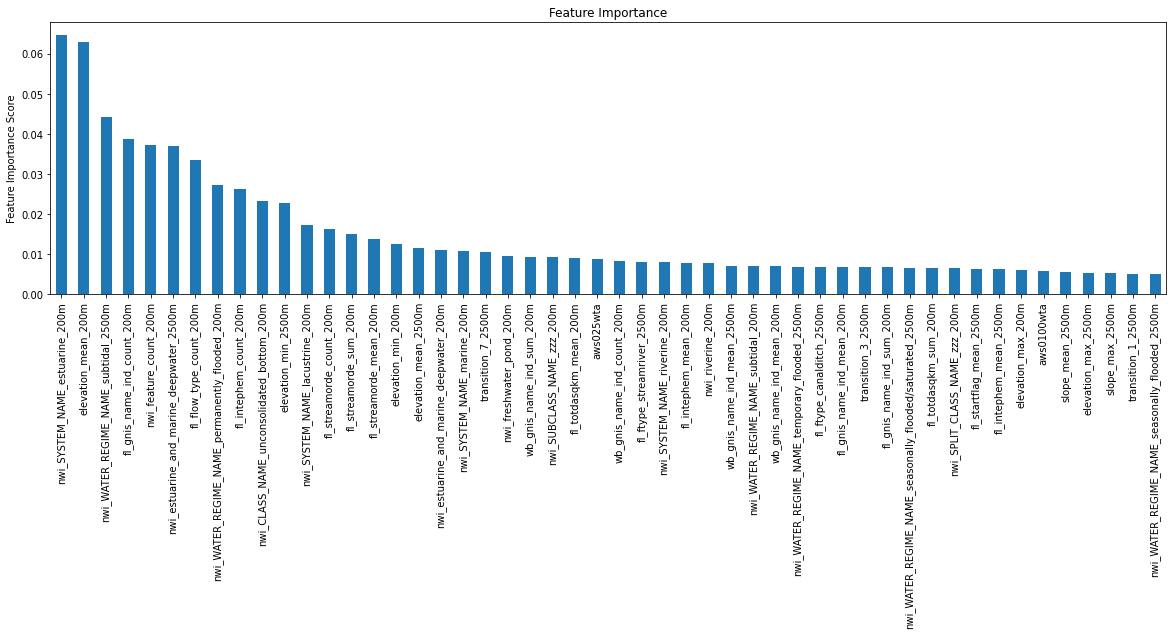

In [605]:
#Feature importance for top 50 predictors
predictors = [x for x in df_X_combined_dummies_ordered.columns]
feat_imp = pd.Series(xgb.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [606]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 3.4


# Light GBM

In [607]:
start = datetime.now()

In [608]:
# https://www.kaggle.com/binilg/lightgbm-with-randomsearchcv-and-feature-imp
# Implementation: https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
# Documentation: https://lightgbm.readthedocs.io/en/latest/Features.html
# LightGBM Classifier: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#

import lightgbm
param_dict = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }
#modelling
clf = lightgbm.LGBMClassifier()

if run_models:
    random_search_model = (RandomizedSearchCV(clf, 
                               param_dict, 
                               verbose=1, 
                               cv=10, 
                               n_jobs = -1, 
                               n_iter=10,
                               scoring='roc_auc'))
        # from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    random_search_model.fit(X, Y)
    model_dict["lgbm"] = random_search_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


In [609]:
random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
lgbm = random_search_fitted_models["lgbm"]
y_predict = lgbm.predict(test_X) 

# threshold is taken as 0.5, as proven here
# y_predict_ = 1 * (lr.predict_proba(test_X)[:, 1]>0.5) # 
# np.mean(y_predict == y_predict_)

In [610]:
model_results(lgbm, dev_X, dev_Y)

average_precision_score: 0.71548
roc_auc : 0.81404
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1863
           1       0.75      0.48      0.58      1003

    accuracy                           0.76      2866
   macro avg       0.76      0.70      0.71      2866
weighted avg       0.76      0.76      0.75      2866



Text(0, 0.5, 'Feature Importance Score')

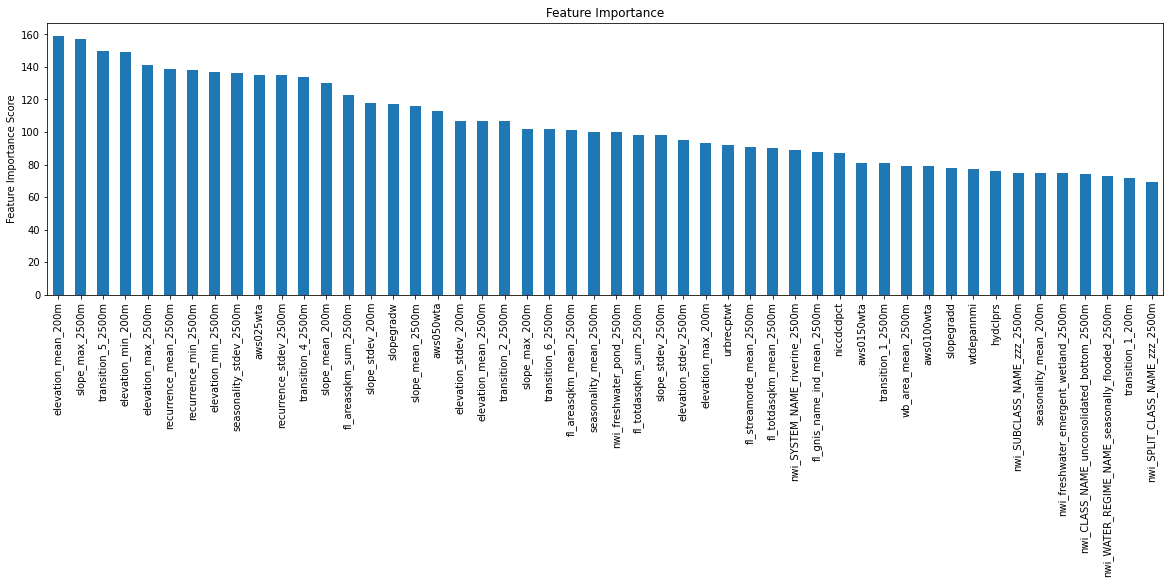

In [611]:
#Feature importance for top 50 predictors
predictors = [x for x in df_X_combined_dummies_ordered.columns]
feat_imp = pd.Series(lgbm.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [612]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.2


In [613]:
# stop

# Stacking

### http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

In [614]:
start = datetime.now()

In [615]:
# classifiers, meta_classifier, use_probas=False, cv=2, 
# use_features_in_secondary=False, stratify=True, shuffle=True, verbose=0, store_train_meta_features=False, use_clones=True)

random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
xgb = random_search_fitted_models["xgb"]
lgbm = random_search_fitted_models["lgbm"]

if run_models:
    stack_gen_model = (StackingCVClassifier(classifiers=[xgb.best_estimator_,
                                                         lgbm.best_estimator_], 
                                            meta_classifier=xgb.best_estimator_,
                                            use_features_in_secondary=True,
                                            use_probas=True,
                                           random_state=random_state))

    stack_gen_model.fit(X, Y)
    model_dict["stacking"] = stack_gen_model
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)
    
random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
stacking = random_search_fitted_models["stacking"]
y_predict = stacking.predict(test_X) 
y_score = stacking.predict_proba(test_X)

[23:48:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[23:48:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [616]:
# Compute ROC curve and ROC area for each class
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()


fpr, tpr, _ = roc_curve(test_Y, y_score[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(test_Y.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plt.figure()
# lw = 2
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

0.8042368526993813

In [617]:
model_results(stack_gen_model, test_X, test_Y)

average_precision_score: 0.72547
roc_auc : 0.80424
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1840
           1       0.74      0.50      0.60      1026

    accuracy                           0.76      2866
   macro avg       0.75      0.70      0.71      2866
weighted avg       0.76      0.76      0.75      2866



In [618]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 0.1


# VotingClassifier

In [619]:
start = datetime.now()

In [620]:
if run_models:
    vc_clf = (VotingClassifier(estimators=[("xbg", random_search_fitted_models["xgb"]), 
                                           ("lightgbm", random_search_fitted_models["lgbm"]),
                                          ("stacking", random_search_fitted_models["stacking"])],
                                           voting="soft",
                                           flatten_transform=False))

    vc_fit = vc_clf.fit(dev_X, dev_Y)
    model_dict["voting_clf"] = vc_fit
    model_dict["file_params"] = file_param_dict
    pickle.dump(model_dict, open("random_search_fitted_models_" + FILE_VERSION, "wb"), protocol=3)

random_search_fitted_models = pd.read_pickle("random_search_fitted_models_" + FILE_VERSION)
voting_clf = random_search_fitted_models["voting_clf"]
y_predict = voting_clf.predict(test_X) 
y_score = voting_clf.predict_proba(test_X)

[23:50:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[23:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_

In [621]:
model_results(vc_fit, test_X, test_Y)

average_precision_score: 0.69386
roc_auc : 0.77845
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81      1840
           1       0.71      0.44      0.54      1026

    accuracy                           0.74      2866
   macro avg       0.73      0.67      0.68      2866
weighted avg       0.73      0.74      0.72      2866



In [622]:
end = datetime.now()
time_taken(start, end)

Time taken (min): 2.5


# Model Comparison

In [623]:
model_dict.keys()

dict_keys(['lr', 'file_params', 'xgb', 'lgbm', 'stacking', 'voting_clf'])

In [624]:
def model_results(fitted_model, test_X, test_Y):
#     print("accuracy:", np.mean(test_Y == log_best_model.predict(test_X)))
#     print("balanced_accuracy_score:", balanced_accuracy_score(test_Y, log_best_model.predict(test_X)))

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
    # AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
    print("average_precision_score:", round(metrics.average_precision_score(test_Y, fitted_model.predict_proba(test_X)[:, 1], average="weighted"), 5))
    
    y_prob = fitted_model.predict_proba(test_X)
    fpr, tpr, thresholds = metrics.roc_curve(test_Y, y_prob[:, 1], pos_label=1)
    print("roc_auc",":", round(metrics.auc(fpr, tpr), 5))
    
    print("Classification Report:") # threshold agnostic because you pass in the test labels instead of scores (probabilities)
    print(classification_report(test_Y, fitted_model.predict(test_X)))

In [625]:
model_dict.keys()

dict_keys(['lr', 'file_params', 'xgb', 'lgbm', 'stacking', 'voting_clf'])

In [626]:
print("ROC_AUC on Test")
print("===============")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), test_X, test_Y)))

ROC_AUC on Test
lr:           0.65309
xgb:          0.75117
lgbm:         0.80626
stacking:     0.80424
voting_clf:   0.77845


In [627]:
print("ROC_AUC on Dev")
print("==============")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), dev_X, dev_Y)))

ROC_AUC on Dev
lr:           0.66251
xgb:          0.76095
lgbm:         0.81404
stacking:     0.80352
voting_clf:   0.97259


In [628]:
print("ROC_AUC on Training")
print("===================")
for model in model_dict.keys():
    if model not in ["file_params"]:
        print("{}:{}{}".format(model, " "*(13 - len(model)), find_roc_auc(model_dict.get(model), X, Y)))

ROC_AUC on Training
lr:           0.65788
xgb:          0.78112
lgbm:         0.97659
stacking:     0.95548
voting_clf:   0.77717


# Residual Analysis

In [632]:
array1 = np.array(df_test)
model = "lgbm"
y_predict = model_dict[model].predict(test_X)
array2 = y_predict.reshape(2866,1)
array3 = np.hstack((array1, array2))
df_pred = pd.DataFrame(array3, columns = list(df_test.columns) + ["predictions"])
df_pred.head()

,cwa4,cwa8,cwa7,cwa_determination,cwa5,longitude,cwa3,date_issued_or_denied,latitude,Index,...,nwi_SPLIT_SUBCLASS_NAME_lichen_2500m,nwi_WATER_REGIME_NAME_zzz_2500m,nwi_WATER_REGIME_NAME_permanently_flooded_2500m,nwi_SPLIT_CLASS_NAME_emergent_2500m,nwi_WATER_REGIME_SUBGROUP_zzz_2500m,nwi_WATER_REGIME_SUBGROUP_freshwater_tidal_2500m,nwi_CLASS_NAME_rocky_shore_2500m,county,state,predictions
0,0,0,0,0,0,-80.0571,0,09/21/2016,33.0255,8361,...,0,0,0,0,0,0,0,Berkeley,45,0
1,0,0,0,0,0,-90.7142,0,09/14/2017,36.3323,14006,...,0,0,1,0,0,0,0,Clay,05,0
2,0,0,0,1,0,-80.3632,1,03/03/2016,33.6177,14477,...,0,0,0,0,0,0,0,Clarendon,45,0
3,0,0,0,0,0,-91.1907,0,11/23/2016,32.0013,2351,...,0,0,5,0,0,0,0,Tensas,22,0
4,0,0,0,0,0,-93.5916,0,07/15/2016,32.4645,2165,...,0,0,0,0,0,0,0,Bossier,22,0


In [633]:
# false negatives

df_fn = df_pred[(df_pred.predictions == 0) & (df_pred.cwa_determination == 1)]
df_fn.head()

,cwa4,cwa8,cwa7,cwa_determination,cwa5,longitude,cwa3,date_issued_or_denied,latitude,Index,...,nwi_SPLIT_SUBCLASS_NAME_lichen_2500m,nwi_WATER_REGIME_NAME_zzz_2500m,nwi_WATER_REGIME_NAME_permanently_flooded_2500m,nwi_SPLIT_CLASS_NAME_emergent_2500m,nwi_WATER_REGIME_SUBGROUP_zzz_2500m,nwi_WATER_REGIME_SUBGROUP_freshwater_tidal_2500m,nwi_CLASS_NAME_rocky_shore_2500m,county,state,predictions
2,0,0,0,1,0,-80.3632,1,03/03/2016,33.6177,14477,...,0,0,0,0,0,0,0,Clarendon,45,0
10,0,0,0,1,1,-97.4055,0,02/16/2016,48.3978,14421,...,0,0,0,0,0,0,0,Walsh,38,0
14,0,0,0,1,0,-79.9765,0,07/18/2017,32.8737,8882,...,0,0,0,0,0,0,0,Charleston,45,0
32,0,0,0,1,0,-78.9541,0,03/25/2016,33.6831,8566,...,0,0,0,0,0,0,0,Horry,45,0
37,0,0,0,1,1,-80.2389,1,06/28/2016,32.7858,8585,...,0,0,0,0,0,0,0,Charleston,45,0


In [641]:
imp_cols = ['cwa1', 'cwa2', 'cwa3', 'cwa4', 'cwa5', 'cwa6' , 'cwa7', 'cwa8', 'cwa9', 'cwa_determination','longitude', 'latitude', 'Index','da_number',
       'jurisdiction_type', 'potential_wetland', "predictions"]
df_fn[imp_cols]

,cwa1,cwa2,cwa3,cwa4,cwa5,cwa6,cwa7,cwa8,cwa9,cwa_determination,longitude,latitude,Index,da_number,jurisdiction_type,potential_wetland,predictions
2,0,0,1,0,0,0,0,0,0,1,-80.3632,33.6177,14477,SAC-2016-00032,RAPANOS,1,0
10,0,0,0,0,1,0,0,0,0,1,-97.4055,48.3978,14421,NWO-2014-01892-BIS,RAPANOS,1,0
14,1,1,0,0,0,0,0,0,0,1,-79.9765,32.8737,8882,SAC-2017-00212,RAPANOS,0,0
32,0,0,0,0,0,1,0,0,0,1,-78.9541,33.6831,8566,SAC-2016-00514,RAPANOS,1,0
37,0,0,1,0,1,0,0,0,0,1,-80.2389,32.7858,8585,SAC-2016-00641,RAPANOS,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,0,0,1,0,0,1,0,0,0,1,-84.9491,39.8566,1527,LRL-2017-01114-sjk,RAPANOS,1,0
2844,0,0,1,1,0,0,1,0,0,1,-94.9311,38.7821,6907,NWK-2019-00658,RAPANOS,0,0
2847,0,0,1,0,1,1,0,0,0,1,-91.0219,30.5089,3860,MVN-2018-00027-SG,RAPANOS,1,0
2855,0,0,1,0,0,0,0,0,0,1,-82.0978,34.1508,9252,SAC-2018-00025,RAPANOS,1,0


In [640]:
model = "lgbm"
model_results(model_dict[model], test_X, test_Y)
confusion_matrix(test_Y, model_dict[model].predict(test_X))

average_precision_score: 0.72891
roc_auc : 0.80626
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1840
           1       0.77      0.50      0.60      1026

    accuracy                           0.76      2866
   macro avg       0.76      0.71      0.72      2866
weighted avg       0.76      0.76      0.75      2866



array([[1684,  156],
       [ 518,  508]])

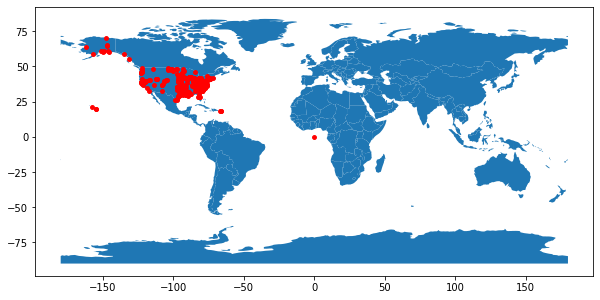

In [648]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
geometry = [Point(xy) for xy in zip(df_fn['longitude'], df_fn['latitude'])]
gdf = GeoDataFrame(df_fn, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

# Break


In [629]:
y_predict = model_dict["lgbm"].predict(test_X)

temp = pd.DataFrame(np.vstack((test_Y, y_predict)).transpose(), columns=["label", "prediction"])
df_test_X[temp.loc[temp.label != temp.prediction].index]
# temp.shape

# temp.loc[temp.label != temp.prediction][temp.label == 1]

KeyError: "None of [Int64Index([   2,   10,   14,   27,   32,   37,   38,   39,   40,   41,\n            ...\n            2838, 2840, 2841, 2843, 2844, 2846, 2847, 2849, 2855, 2857],\n           dtype='int64', length=674)] are in the [columns]"

In [ ]:
test_Y

In [ ]:

random_search_fitted_models["xgb"].__dir__()

In [ ]:
random_search_fitted_models["lgbm"].cv_results_#["param_num_leaves"]